In [1]:
import networkx as nx
import numpy as np
import torch_geometric
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 

import matplotlib.pyplot as plt

from torch_geometric.data import Dataset, Data
from torch_geometric.loader.dataloader import DataLoader

from GraphDataset import RandomGraphDataset
from GraphToSequence import graphToSequence, sequenceToGraph

from SimpleTransformer import SimpleTransformer
from lang import Lang

In [2]:
data_folder_training = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_training"
data_folder_test = "/eos/user/c/czeh/graphsequencer/fixed_edge_graph_test"


dataset_training = RandomGraphDataset(data_folder_training, nodes=100, edges=20, data_count=1000)
dataset_test = RandomGraphDataset(data_folder_test, nodes=100,  edges=20, data_count=50)

In [3]:
def generate_data(num_samples, seq, converter, seq_length):
    tensor = torch.zeros((num_samples, seq_length+1), dtype=torch.long)
    
    idx = np.random.randint(0, len(seq)-3, (num_samples,))
    length = np.random.randint(0, len(seq), (num_samples,))

    for i in range(num_samples):
        tensor[i, :] = torch.tensor(converter.subseq2arr(seq, seq_length+1, idx[i], length[i]+1))
        
    return tensor[:,:-1], tensor[:,1:]

In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [5]:
# Generating data
seq = "4.8.;13.11.(12.6.(7.9.10.5.*6.3.1.2.*11.))"
sequence_length = 10
num_samples = 1000
batch_size = 256

converter = Lang(13)
vocab_size = converter.n_words
inputs, targets = generate_data(num_samples, seq, converter, sequence_length)

# Create a TensorDataset to hold the inputs and targets
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
inputs

tensor([[ 0,  0,  0,  ...,  7,  5,  5],
        [ 0,  7,  4,  ...,  9,  8,  7],
        [16,  7,  3,  ...,  9,  7,  4],
        ...,
        [ 0,  0, 10,  ...,  7,  5,  5],
        [ 7,  6, 14,  ...,  7, 10,  7],
        [ 9,  9,  7,  ..., 14,  7,  4]])

In [7]:
targets

tensor([[ 0,  0,  0,  ...,  5,  5,  2],
        [ 7,  4, 15,  ...,  8,  7, 13],
        [ 7,  3,  9,  ...,  7,  4,  9],
        ...,
        [ 0, 10,  7,  ...,  5,  5,  2],
        [ 6, 14,  7,  ..., 10,  7,  2],
        [ 9,  7,  4,  ...,  7,  4, 15]])

In [8]:
embed_size = 512
learning_rate = 0.001
epochs = 5

# Model, loss, and optimizer
model = SimpleTransformer(embed_size, sequence_length, vocab_size).to(device)
loss_fn = nn.CrossEntropyLoss()

# Optionally introduce weight decay
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
losses_per_epoch = []

# Optionally introduce gradient clipping
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for input_batch, target_batch in dataloader:
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        optimizer.zero_grad()
        output = model(input_batch)
        loss = loss_fn(output.view(-1, vocab_size), target_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {loss:.6f}")
    losses_per_epoch.append(loss)

Epoch 1, Loss: 3.215110
Epoch 2, Loss: 1.709447
Epoch 3, Loss: 1.334484
Epoch 4, Loss: 1.215770
Epoch 5, Loss: 1.113353


Text(0.5, 1.0, 'Training Loss')

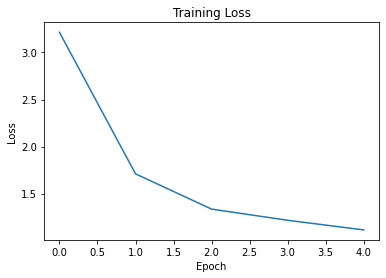

In [10]:
plt.plot(losses_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

In [11]:
correct = 0
for i in range(0, len(seq)+1):
    
    input_seq = converter.subseq2arr(seq, sequence_length+1, max(i-sequence_length-1, 0), min(i+1, sequence_length+1))
    sample_tensor = (torch.tensor(input_seq[:-1], dtype=torch.long).unsqueeze(0).to(device))

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for inference
        predictions = model(sample_tensor)
        predicted_index = predictions.argmax(-1)  # Get the index of the max log-probability for the last position

    predicted_number = predicted_index[0, -1].item()  # Convert to Python number
    print(f"Input Sequence: {converter.arr2seq(input_seq[1:])}")

    res = torch.roll(sample_tensor, -1, dims=1)
    res[0, -1] = predicted_number 

    print(f"Predicted Sequence: {converter.arr2seq(res[0])}")
    print(f"Correct: {converter.arr2seq(res[0]) == converter.arr2seq(input_seq[1:])}")
    correct += converter.arr2seq(res[0]) == converter.arr2seq(input_seq[1:])

print(f"Percentage of correct guesses: {correct / (len(seq)+1)}")

Input Sequence: <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><SOS>4
Predicted Sequence: <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><SOS><EOS>
Correct: False
Input Sequence: <PAD><PAD><PAD><PAD><PAD><PAD><PAD><SOS>4.
Predicted Sequence: <PAD><PAD><PAD><PAD><PAD><PAD><PAD><SOS>4.
Correct: True
Input Sequence: <PAD><PAD><PAD><PAD><PAD><PAD><SOS>4.8
Predicted Sequence: <PAD><PAD><PAD><PAD><PAD><PAD><SOS>4.1
Correct: False
Input Sequence: <PAD><PAD><PAD><PAD><PAD><SOS>4.8.
Predicted Sequence: <PAD><PAD><PAD><PAD><PAD><SOS>4.8.
Correct: True
Input Sequence: <PAD><PAD><PAD><PAD><SOS>4.8.;
Predicted Sequence: <PAD><PAD><PAD><PAD><SOS>4.8.1
Correct: False
Input Sequence: <PAD><PAD><PAD><SOS>4.8.;1
Predicted Sequence: <PAD><PAD><PAD><SOS>4.8.;1
Correct: True
Input Sequence: <PAD><PAD><SOS>4.8.;13
Predicted Sequence: <PAD><PAD><SOS>4.8.;1.
Correct: False
Input Sequence: <PAD><SOS>4.8.;13.
Predicted Sequence: <PAD><SOS>4.8.;13.
Correct: True
Input Sequence: <SOS>4.8.;13.1
Predicted Sequence: <SOS>4.8.;13.